In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
import global_values
from groups import *
from merge_groups_best_candidate import *
from puzzle import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_values.MODEL = SiameseCNN()
global_values.MODEL.load_state_dict(torch.load("siamese_weights_imbalanced_lr-6.pth", map_location=device))
global_values.MODEL.to(device)
global_values.MODEL.eval()
global_values.DEVICE = device
NN_SCORING = True
ROTATING_PIECES = True



def clasic_score_one_image_passing(side_comparison, th = global_values.IMAGE_TH):
    if side_comparison.score < th:
        return True
    return False

def prudent_x_buddy_one_image_passing(side_comparison, th = global_values.PRUDENT_X_BUDDY_TH_IMAGE):
    if side_comparison.prudent_score * side_comparison.buddy_score < th:
        return True
    return False

## mai indicat pt astea mai mari
def safe_clasic_score_one_image_passing(side_comparison, th = 0.015):
    if side_comparison.score < th:
        return True
    return False

def mean_clasic_score(mean, th = global_values.GROUP_TH):
    if mean < th:
        return True
    return False

def no_mean_score(mean, th = 0):
    return True


In [2]:
image = "0477.png"
image_path = os.path.join("all_images",image)

output_folder = "fragments"

global_values.COL_NR = 20
global_values.ROW_NR = 20
solution_path = f"solution/valid_comparisons_{global_values.COL_NR}_{global_values.ROW_NR}{image}.txt"

fragments, tile_h, tile_w = divide_image(image_path, output_folder,solution_path, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)
print("rotation dictionary")
fragment_rotation_dictionary = create_fragment_rotation_dictionary(fragments, tile_h, tile_w)
fragment_rotation_dictionary = create_fragment_rotation_tensor_dictionary(fragment_rotation_dictionary)

print("create side comps")
sides_pairs = create_sides_pairs_for_nn(fragments)
sides_comparisons = create_sides_comparisons_with_score_nn(global_values.MODEL, device,  fragment_rotation_dictionary, sides_pairs)
sides_comparisons = calculate_buddy_score(fragments,sides_comparisons)
print("sort")
sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(c.side2, c.side1, c.score)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp





Rotations by fragment: 0)0.0, 1)0.0, 2)0.0, 3)0.0, 4)0.0, 5)0.0, 6)0.0, 7)0.0, 8)0.0, 9)0.0, 10)0.0, 11)0.0, 12)0.0, 13)0.0, 14)0.0, 15)0.0, 16)0.0, 17)0.0, 18)0.0, 19)0.0, 20)0.0, 21)0.0, 22)0.0, 23)0.0, 24)0.0, 25)0.0, 26)0.0, 27)0.0, 28)0.0, 29)0.0, 30)0.0, 31)0.0, 32)0.0, 33)0.0, 34)0.0, 35)0.0, 36)0.0, 37)0.0, 38)0.0, 39)0.0, 40)0.0, 41)0.0, 42)0.0, 43)0.0, 44)0.0, 45)0.0, 46)0.0, 47)0.0, 48)0.0, 49)0.0, 50)0.0, 51)0.0, 52)0.0, 53)0.0, 54)0.0, 55)0.0, 56)0.0, 57)0.0, 58)0.0, 59)0.0, 60)0.0, 61)0.0, 62)0.0, 63)0.0, 64)0.0, 65)0.0, 66)0.0, 67)0.0, 68)0.0, 69)0.0, 70)0.0, 71)0.0, 72)0.0, 73)0.0, 74)0.0, 75)0.0, 76)0.0, 77)0.0, 78)0.0, 79)0.0, 80)0.0, 81)0.0, 82)0.0, 83)0.0, 84)0.0, 85)0.0, 86)0.0, 87)0.0, 88)0.0, 89)0.0, 90)0.0, 91)0.0, 92)0.0, 93)0.0, 94)0.0, 95)0.0, 96)0.0, 97)0.0, 98)0.0, 99)0.0, 100)0.0, 101)0.0, 102)0.0, 103)0.0, 104)0.0, 105)0.0, 106)0.0, 107)0.0, 108)0.0, 109)0.0, 110)0.0, 111)0.0, 112)0.0, 113)0.0, 114)0.0, 115)0.0, 116)0.0, 117)0.0, 118)0.0, 119)0.0, 120)0.0

100%|██████████| 400/400 [00:00<00:00, 388181.77it/s]


create side comps


100%|██████████| 319200/319200 [00:00<00:00, 1262841.70it/s]


sort


In [3]:
global_values.IMAGE_TH = 0.01
global_values.GROUP_TH = 0.0025

In [4]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

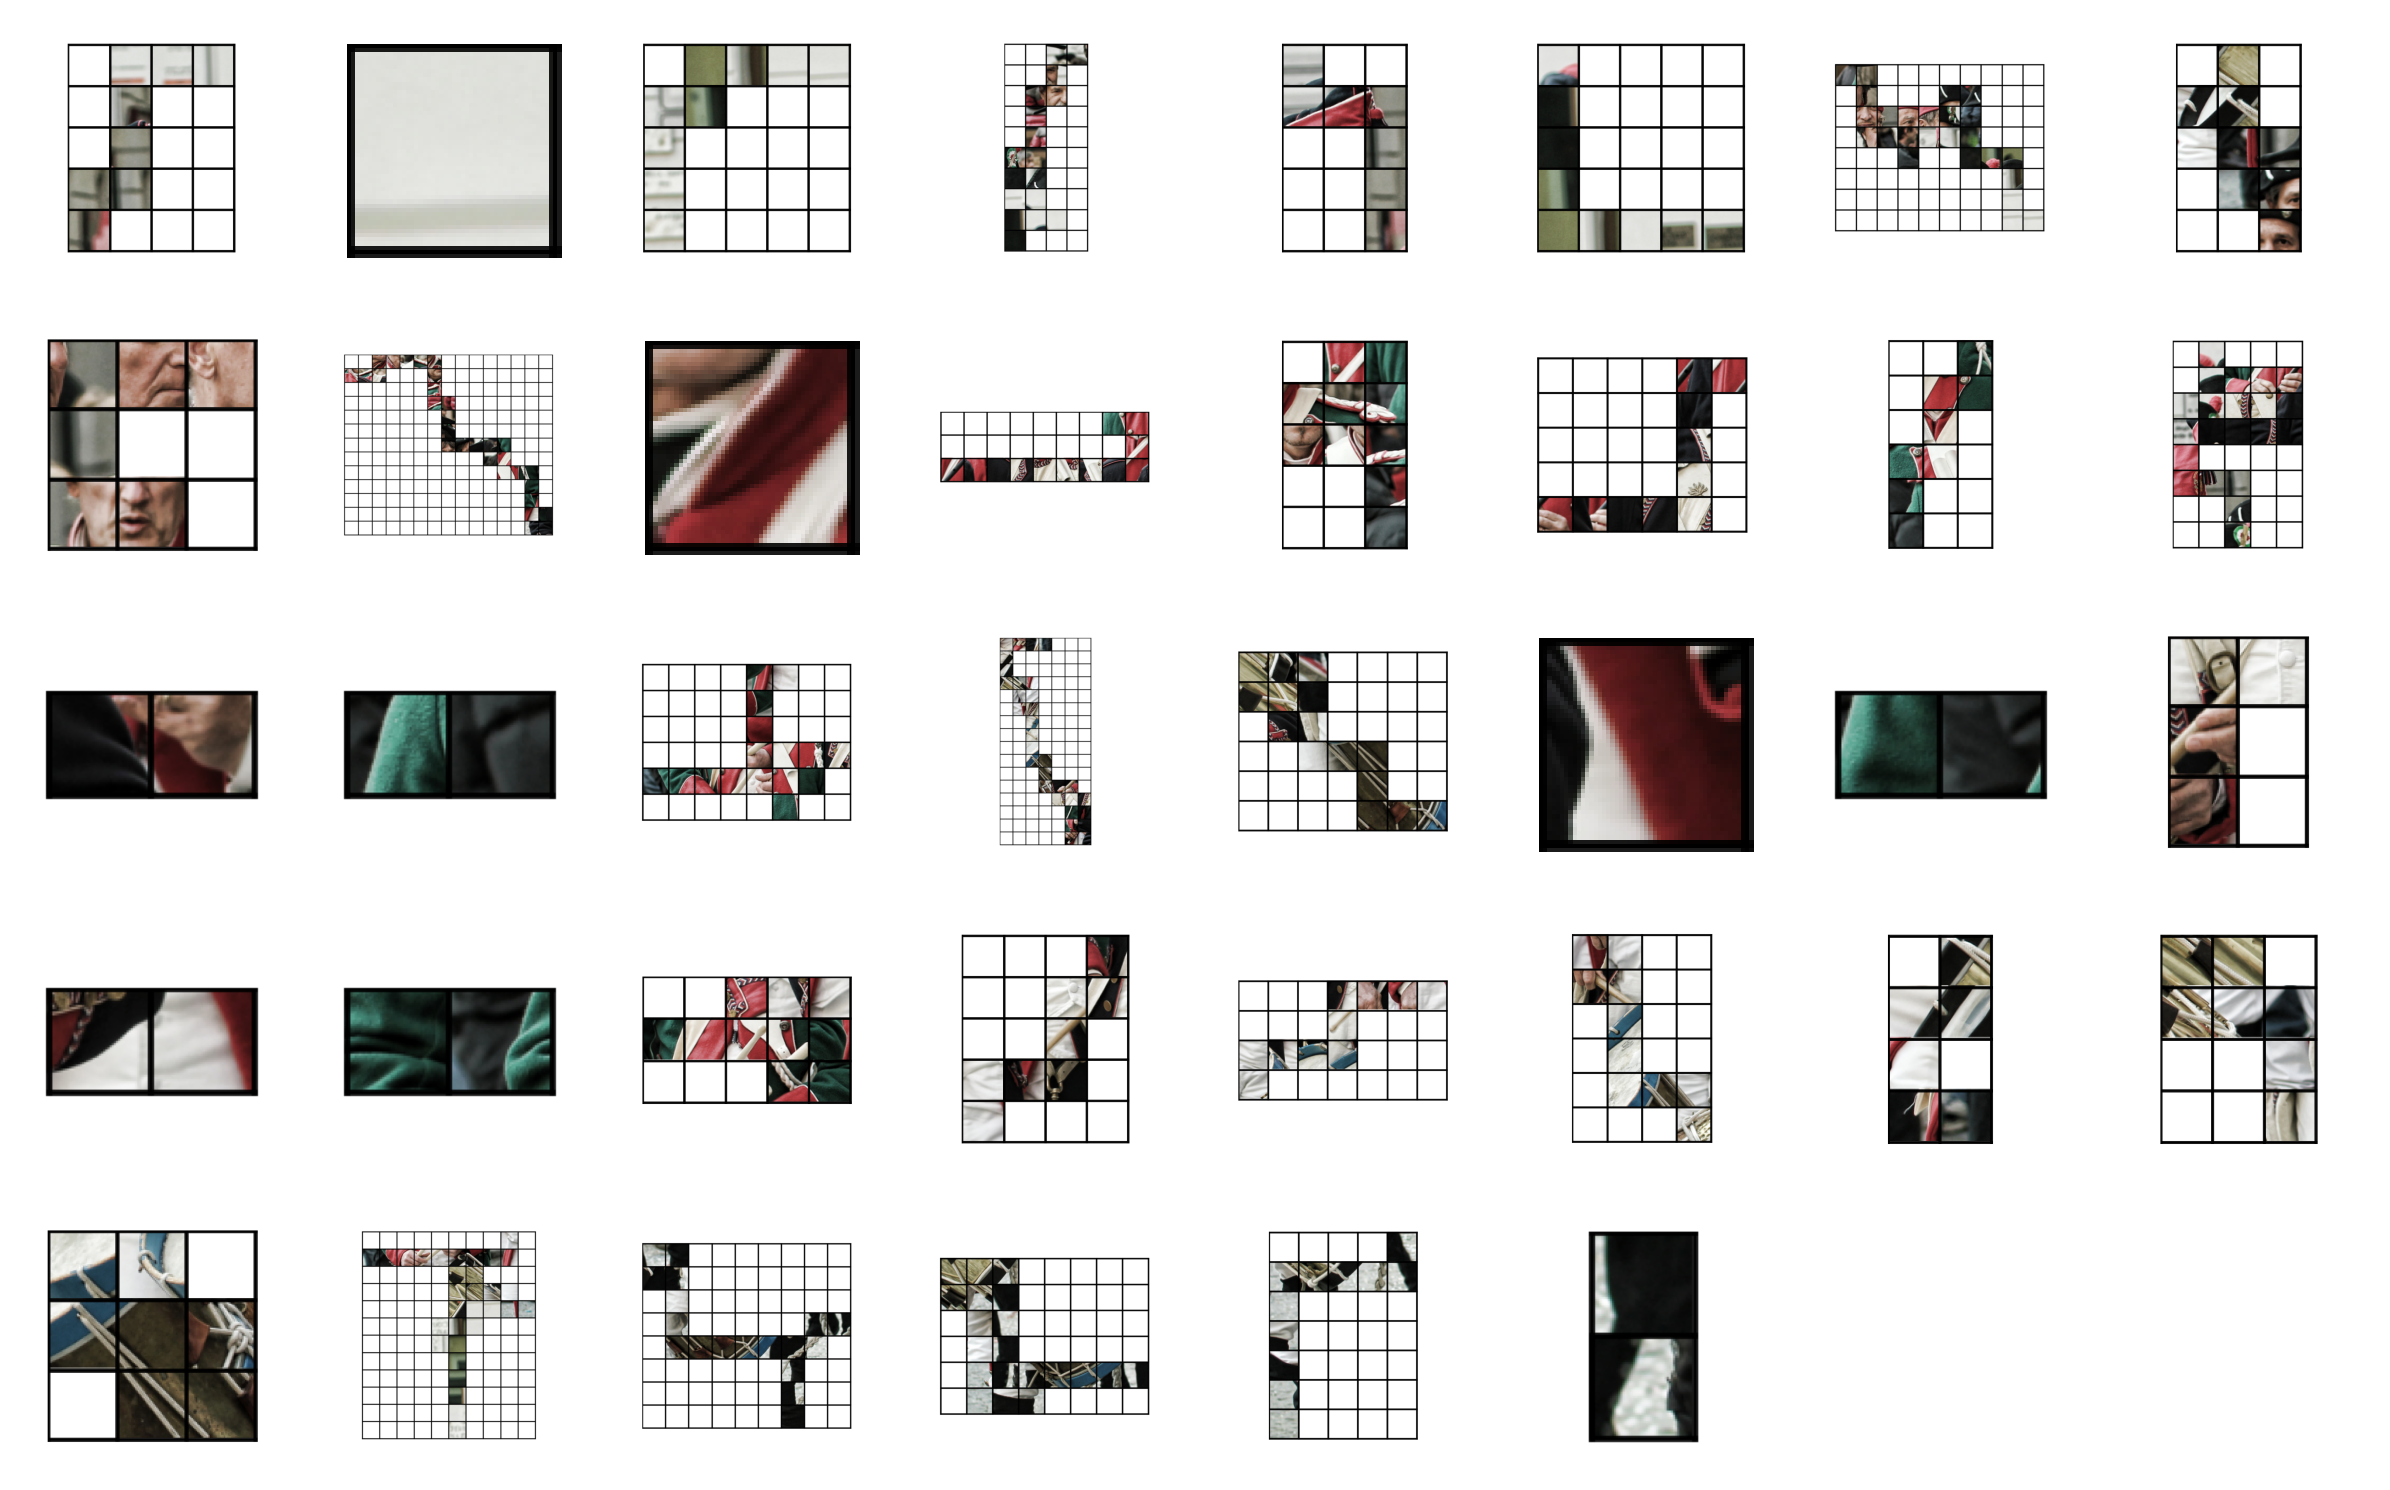

In [5]:
groups, fragments, fragment_idx_to_group_idx = merge_where_obvious(clasic_score_one_image_passing, no_mean_score, 0.001, 0.015, sorted_sides_comparisons, fragment_idx_to_group_idx, fragments, groups)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)


Merged group 15 and 16 with total score: 0.6397957786917686 using: Sides Comp: Score=0.03181277960538864 Buddy_Score:783.607177734375 Fragment_idx1=177, Side_idx1=2; fragment_idx2=178, side_idx2=0
Merged group 32 and 21 with total score: 0.7551952064037323 using: Sides Comp: Score=1.0 Buddy_Score:None Fragment_idx1=267, Side_idx1=2; fragment_idx2=201, side_idx2=0
Merged group 11 and 19 with total score: 0.9996034145355225 using: Sides Comp: Score=1.0 Buddy_Score:21449.71875 Fragment_idx1=128, Side_idx1=2; fragment_idx2=339, side_idx2=0
Merged group 27 and 30 with total score: 0.9999224543571472 using: Sides Comp: Score=1.0 Buddy_Score:None Fragment_idx1=304, Side_idx1=2; fragment_idx2=260, side_idx2=0
Merged group 8 and 11 with total score: 0.9999874830245972 using: Sides Comp: Score=1.0 Buddy_Score:27305.525390625 Fragment_idx1=95, Side_idx1=2; fragment_idx2=139, side_idx2=0
Merged group 8 and 32 with total score: 0.999992847442627 using: Sides Comp: Score=0.9999713897705078 Buddy_Sco

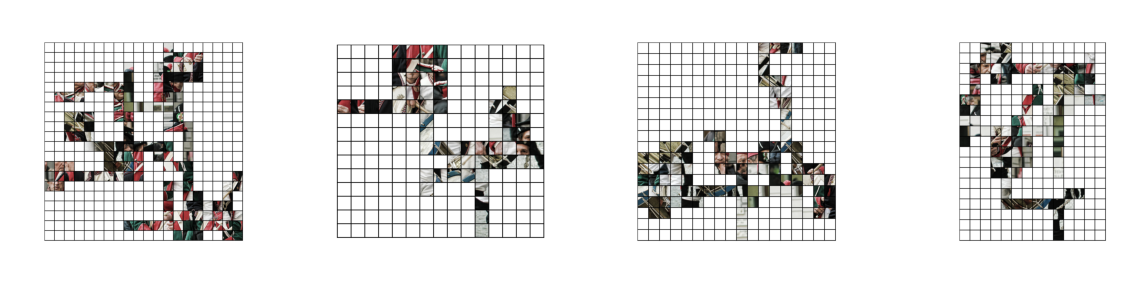

In [6]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [7]:
gt_comparisons = read_valid_comparisons(solution_path)



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 10.263157894736842%


In [8]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
